In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   # ignore warning

# __1. DataFrame Preprocessing__

In [2]:
ts = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts.index = pd.to_datetime(ts.index)
ts

,Marine Gasoil 9_Price
Date,
2022-01-04,775.5
2022-01-05,800.5
2022-01-06,802.5
2022-01-07,806.5
2022-01-10,813.5
...,...
2024-04-16,876.5
2024-04-17,865.5
2024-04-18,859.5


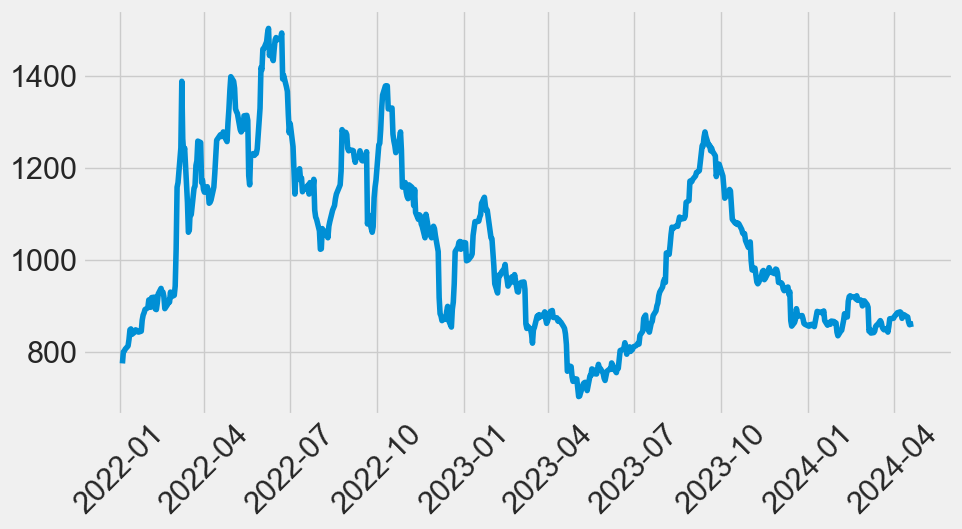

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.xticks(rotation=45)
plt.plot(ts);

# __2. Data Splitting__

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, period=10)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

In [5]:
last_date = ts.index.max()

test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape

((585, 1), (10, 1))

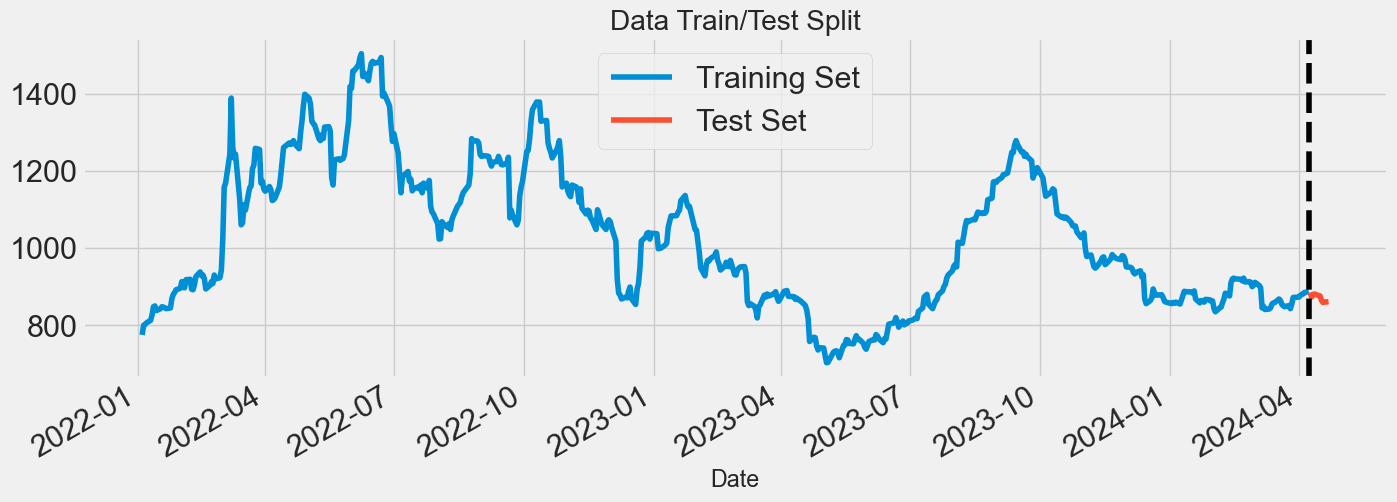

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
train_val.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(test_start_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

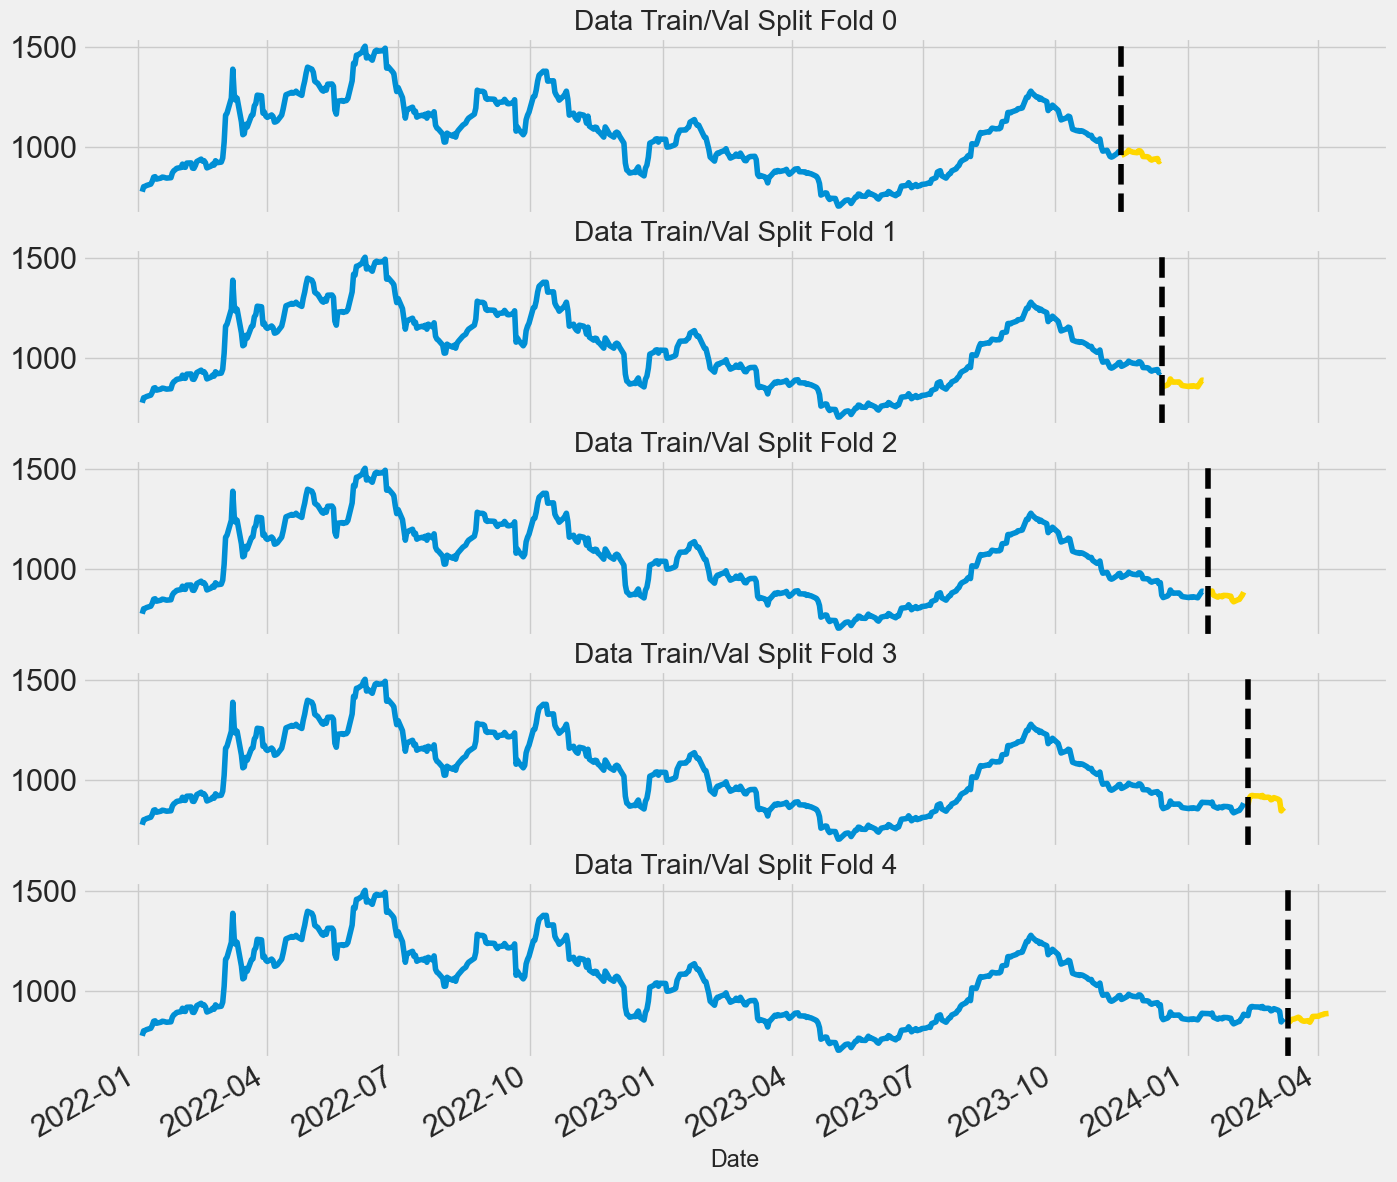

In [7]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 5, test_size=20)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(train_val):
    train = train_val.iloc[train_idx]
    validation = train_val.iloc[val_idx]
    train['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Val Split Fold {fold}')
    validation['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Test Set', color='gold')
    axs[fold].axvline(validation.index.min(), color='black', ls='--')
    fold += 1

plt.show()

# __3. Feature Engineering__

## __3.1 Trend, Seasonal__

In [8]:
train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal

test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal

## __3.2. Simple Rolling Mean Average__

In [9]:
# 이동평균을 추가하는 함수
def add_rolling_mean(df:pd.DataFrame, col_name:str, window_list:list)->pd.DataFrame:
    for window in window_list:
        df[col_name + f'_rolling{window}'] = df[col_name].rolling(window).mean().fillna(method='bfill')
    return df

In [10]:
# 예측하고자 하는 기준이 짧으므로, 단기(5일(1주)) 및 장기 (10일(2주), 20일(1개월), 60일(3개월), 120일(6개월), 240일(1년)) 이동평균 추가
train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])

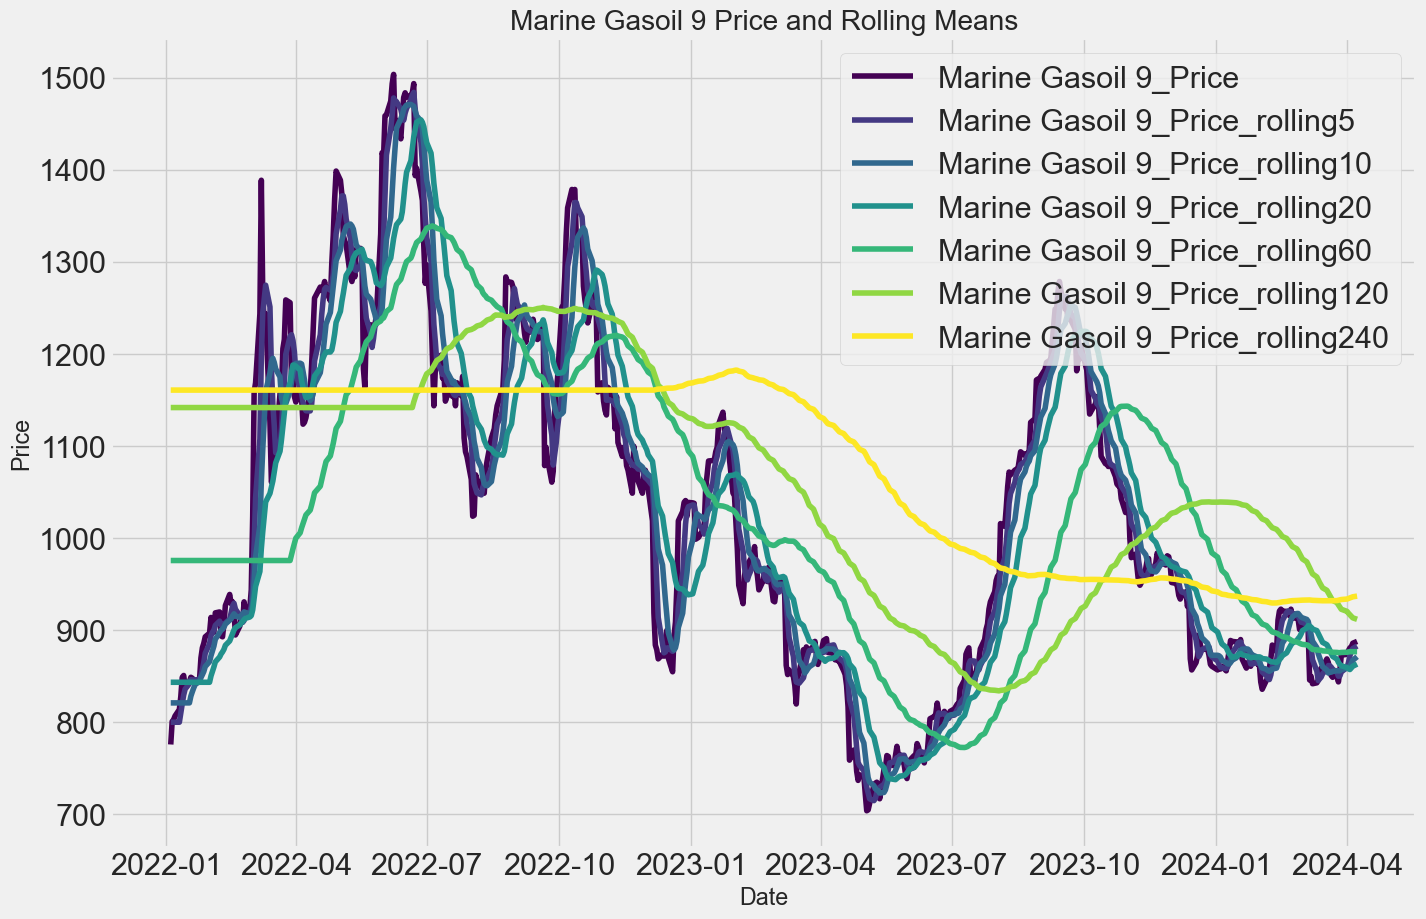

In [11]:
columns_to_plot = [
    'Marine Gasoil 9_Price',
    'Marine Gasoil 9_Price_rolling5',
    'Marine Gasoil 9_Price_rolling10',
    'Marine Gasoil 9_Price_rolling20',
    'Marine Gasoil 9_Price_rolling60',
    'Marine Gasoil 9_Price_rolling120',
    'Marine Gasoil 9_Price_rolling240'
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## __3.3 Lag Feature__ 

In [12]:
def add_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    target_map = df[col_name].to_dict()
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = (df.index - pd.Timedelta(days=days)).map(target_map)
    df = df.fillna(method='bfill').fillna(method='ffill')
    return df

In [13]:
train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])

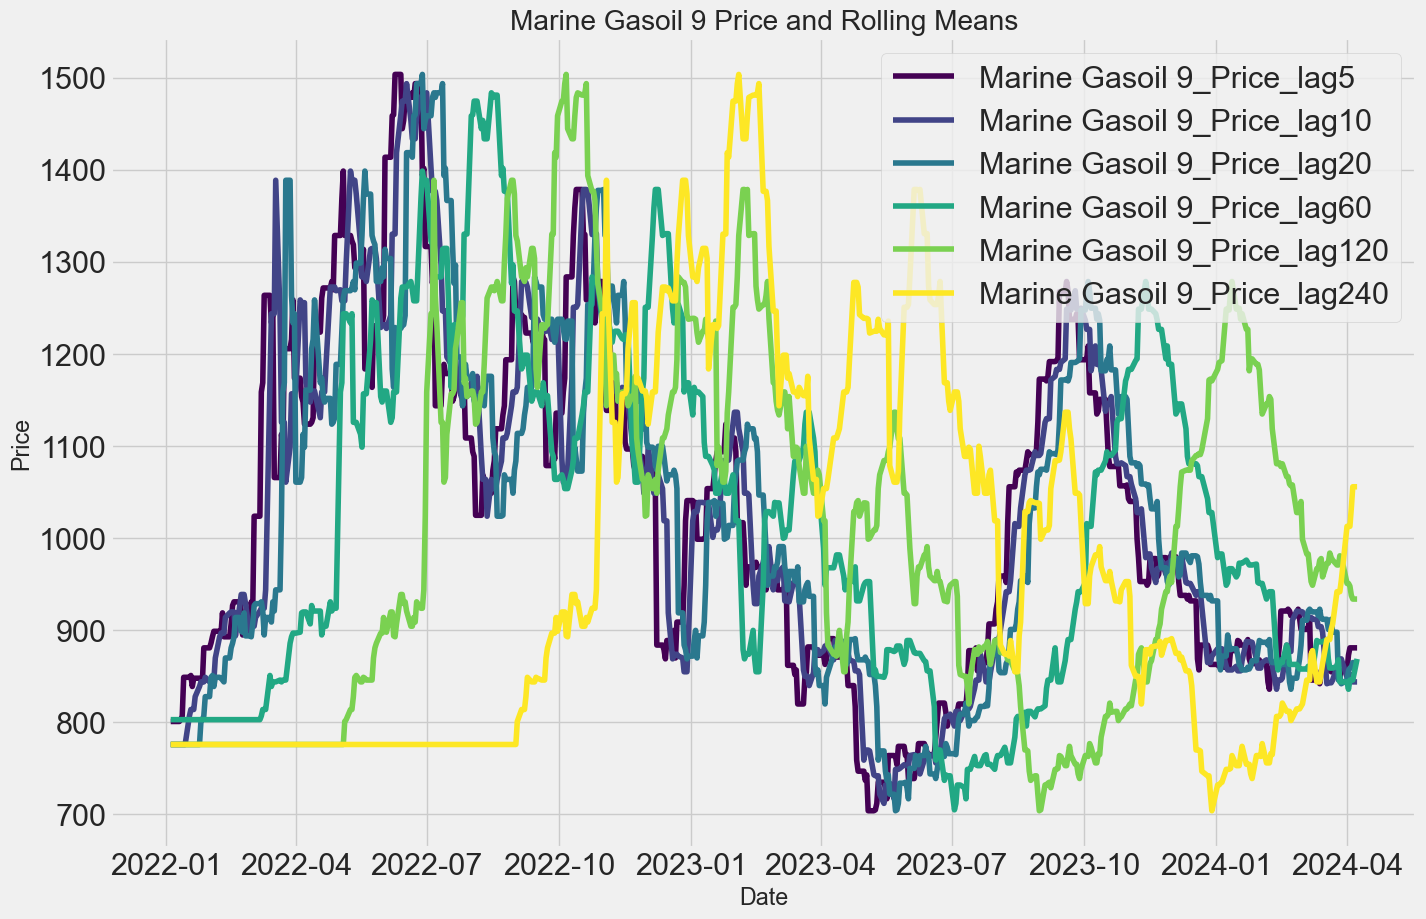

In [14]:
columns_to_plot = [
    'Marine Gasoil 9_Price_lag5',
    'Marine Gasoil 9_Price_lag10',
    'Marine Gasoil 9_Price_lag20',
    'Marine Gasoil 9_Price_lag60',
    'Marine Gasoil 9_Price_lag120',
    'Marine Gasoil 9_Price_lag240'
    ]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## __3.4 Dummies__

In [15]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [16]:
train_val

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rolling5,Marine Gasoil 9_Price_rolling10,Marine Gasoil 9_Price_rolling20,Marine Gasoil 9_Price_rolling60,Marine Gasoil 9_Price_rolling120,Marine Gasoil 9_Price_rolling240,Marine Gasoil 9_Price_lag5,...,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,Marine Gasoil 9_Price_lag240,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,775.5,824.35,-5.231626,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,1,4,1,4
2022-01-05,800.5,824.35,-3.915246,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,2,5,1,5
2022-01-06,802.5,824.35,-0.995419,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,3,6,1,6
2022-01-07,806.5,824.35,2.860041,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,4,7,1,7
2022-01-10,813.5,824.35,6.379868,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,800.5,...,802.5,775.5,775.5,2022,1,1,0,10,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02,877.5,872.60,-5.231626,864.5,859.2,857.80,876.083333,918.108333,934.102083,872.5,...,835.5,950.5,1012.5,2024,2,4,1,2,14,93
2024-04-03,880.5,875.80,-3.915246,871.9,860.8,856.95,876.316667,916.375000,934.677083,880.5,...,845.5,947.5,1012.5,2024,2,4,2,3,14,94
2024-04-04,881.5,878.45,-0.995419,877.1,863.5,858.75,876.383333,914.716667,935.260417,880.5,...,845.5,937.5,1032.5,2024,2,4,3,4,14,95


# __4.Cross Validation__

In [17]:
validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((565, 22), (20, 22), (10, 22))

In [18]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [19]:
# 모델 정의
xgb_model = XGBRegressor(
    base_score=0.5, booster='gbtree',
    n_estimators=10000, early_stopping_rounds=50,
    objective='reg:linear', max_depth=6,
    learning_rate=0.01, min_child_weight=1,
    subsample=0.8, colsample_bytree=0.8,
    gamma=0, reg_alpha=0, reg_lambda=1,
    random_state=42
)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1230.25511
[100]	validation_0-rmse:494.45316
[200]	validation_0-rmse:226.02144
[300]	validation_0-rmse:135.10766
[400]	validation_0-rmse:101.19688
[500]	validation_0-rmse:91.14251
[600]	validation_0-rmse:86.95058
[700]	validation_0-rmse:84.89721
[800]	validation_0-rmse:83.66900
[900]	validation_0-rmse:82.80818
[1000]	validation_0-rmse:82.30576
[1100]	validation_0-rmse:82.04548
[1200]	validation_0-rmse:81.92247
[1300]	validation_0-rmse:81.87804
[1400]	validation_0-rmse:81.86512
[1500]	validation_0-rmse:81.85530
[1537]	validation_0-rmse:81.85612
[0]	validation_0-rmse:1068.72348
[100]	validation_0-rmse:398.28454
[200]	validation_0-rmse:153.13740
[300]	validation_0-rmse:70.95779
[400]	validation_0-rmse:48.62670
[500]	validation_0-rmse:43.80526
[600]	validation_0-rmse:42.91436
[700]	validation_0-rmse:42.81873
[703]	validation_0-rmse:42.81601
[0]	validation_0-rmse:811.08193
[100]	validation_0-rmse:262.96265
[200]	validation_0-rmse:87.38060
[300]	validation_0-rmse:41.517

In [21]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [60.159824646625324, 34.6920417706991, 33.05182388148357, 19.262347349186534, 10.226303887121457]
Average MAE across folds: 31.48
RMSE for each fold: [81.8547825607158, 42.8085337120415, 39.40604016723331, 24.480109636923565, 13.052350177988968]
Average RMSE across folds: 40.32
MAPE for each fold: [4.596477913823792, 3.349799151008222, 4.098875669071482, 1.7999273146825423, 1.1555027269487488]
Average MAPE across folds: 3.00


# __5. XGBoost__

In [22]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:880.49898
[100]	validation_0-rmse:325.36442
[200]	validation_0-rmse:120.87443
[300]	validation_0-rmse:46.53571
[400]	validation_0-rmse:21.70687
[500]	validation_0-rmse:14.80199
[600]	validation_0-rmse:13.29643
[700]	validation_0-rmse:13.06145
[743]	validation_0-rmse:13.06141


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [23]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,prediction_xgb_val_cv,prediction_xgb_cv
Date,,,
2022-01-04,775.5,NaN,NaN
2022-01-05,800.5,NaN,NaN
2022-01-06,802.5,NaN,NaN
2022-01-07,806.5,NaN,NaN
2022-01-10,813.5,NaN,NaN
...,...,...,...
2024-04-16,876.5,NaN,863.459595
2024-04-17,865.5,NaN,864.840393
2024-04-18,859.5,NaN,866.926331


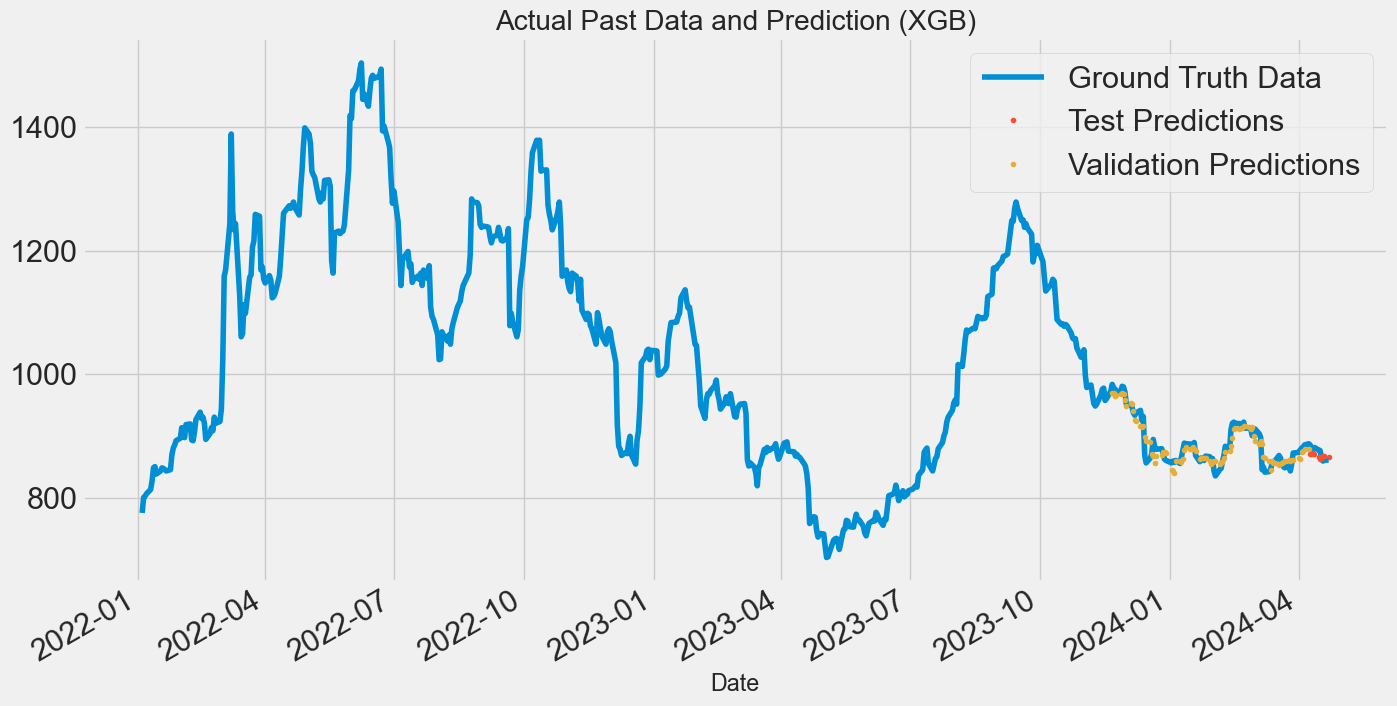

In [24]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_cv'].plot(ax=ax, style='.')
ts['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

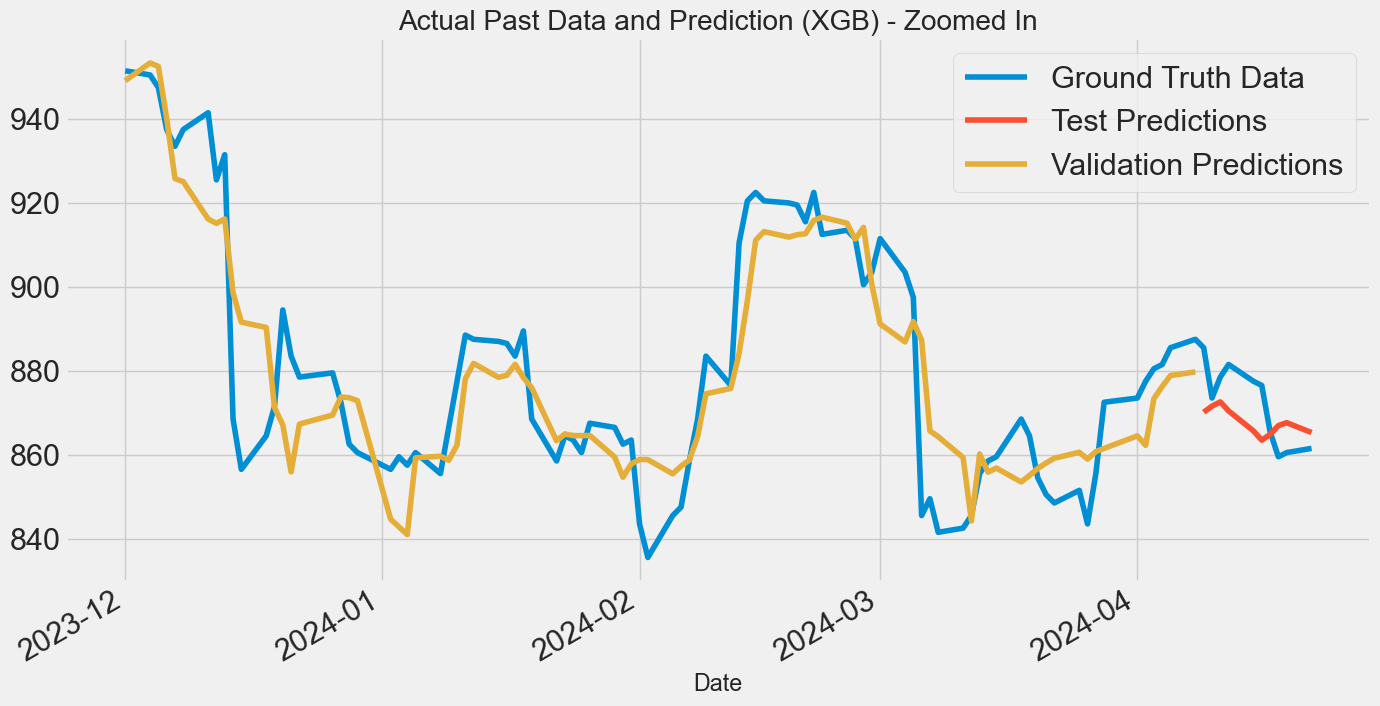

In [25]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-12-01'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

## __5.1 Performance__

In [26]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 10.23
RMSE Score on Validation set (XGB): 13.05
MAPE Score on Validation set (XGB): 1.16%


In [27]:
ts_clean = ts.dropna(subset=['prediction_xgb_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 7.82
RMSE Score on Validation set (XGB): 9.10
MAPE Score on Validation set (XGB): 0.89%


## __5.2. SHAP__

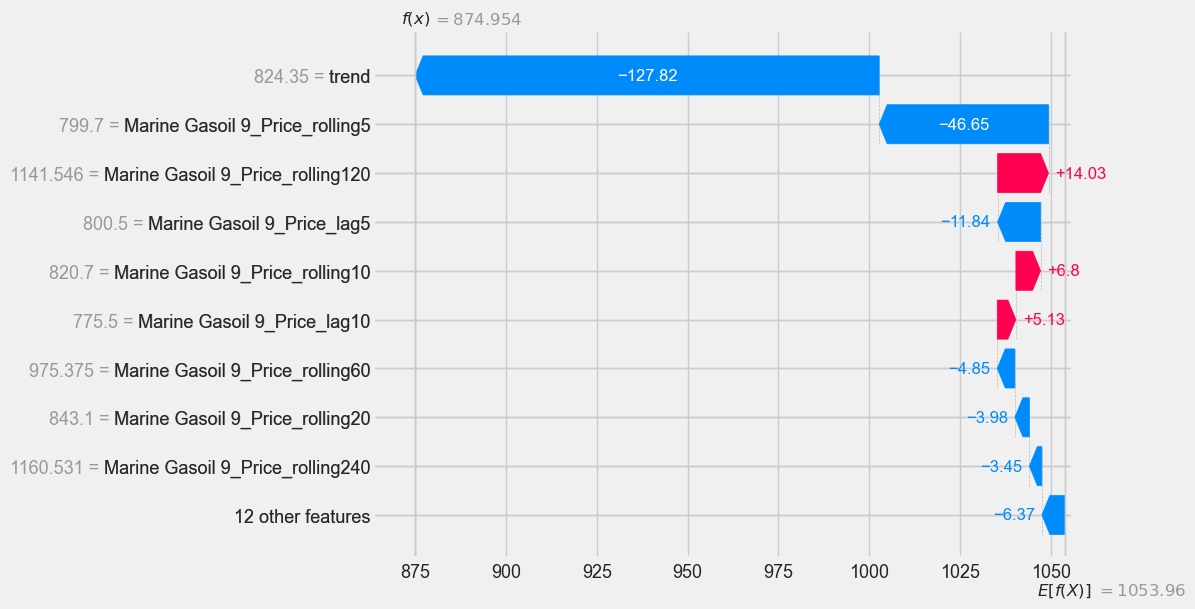

In [28]:
import shap

xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))